Found 1120 images belonging to 4 classes.
Found 480 images belonging to 4 classes.
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 240, 240, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 246, 246, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 120, 120, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 120, 120, 64)         256       ['conv1_conv[0][0]']          
 on)     

c:\Users\huseyindogan\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


70/70 [==============================] - 317s 4s/step - loss: 1.1558 - accuracy: 0.5232 - val_loss: 1.5623 - val_accuracy: 0.2604 - lr: 1.0000e-04
Epoch 2/25
70/70 [==============================] - ETA: 0s - loss: 0.6019 - accuracy: 0.8339
Epoch 2: val_accuracy did not improve from 0.26042
70/70 [==============================] - 286s 4s/step - loss: 0.6019 - accuracy: 0.8339 - val_loss: 1.4828 - val_accuracy: 0.2604 - lr: 1.0000e-04
Epoch 3/25
70/70 [==============================] - ETA: 0s - loss: 0.4671 - accuracy: 0.8929
Epoch 3: val_accuracy improved from 0.26042 to 0.68958, saving model to best_resnet_model_130.h5
70/70 [==============================] - 278s 4s/step - loss: 0.4671 - accuracy: 0.8929 - val_loss: 1.0351 - val_accuracy: 0.6896 - lr: 1.0000e-04
Epoch 4/25
70/70 [==============================] - ETA: 0s - loss: 0.3948 - accuracy: 0.9339
Epoch 4: val_accuracy improved from 0.68958 to 0.92500, saving model to best_resnet_model_130.h5
70/70 [=========================

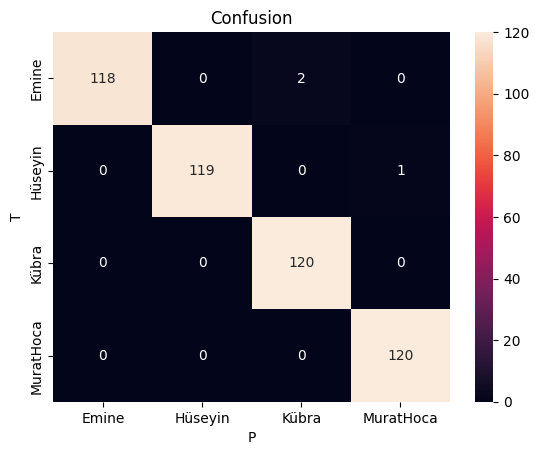

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import os



img_height = 240
img_width = 240
num_classes = 4
batch_size = 16

train_dir = r"train"

val_dir = r"val"



train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    zoom_range=0.15,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest'
)


val_datagen = ImageDataGenerator(
    rescale=1./255
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',  
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical', 
    shuffle=False
)
def build_resnet50(input_shape=(img_height, img_width, 3), num_classes=num_classes, frozen_layers=130):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    for layer in base_model.layers:
        layer.trainable = False
 
    for layer in base_model.layers[-frozen_layers:]:
        layer.trainable = True

    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    l2_strength = 5e-5
    for units, rate in [ (256, 0.4), (128, 0.4), (64, 0.4)]:
        x = Dense(units, kernel_initializer='he_uniform',
                  kernel_regularizer=regularizers.l2(l2_strength))(x)
        x = BatchNormalization()(x)
        x = tf.keras.layers.ReLU()(x)
        x = Dropout(rate)(x)

    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=outputs)
    return model

model = build_resnet50()

model.summary()


optimizer = Adam(learning_rate=1e-4)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

steps_per_epoch = len(train_generator)  
validation_steps = len(val_generator)

checkpoint = ModelCheckpoint("best_resnet_model_130.h5", monitor='val_accuracy', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

history = model.fit(train_generator, epochs=25,validation_data=val_generator,
                    steps_per_epoch=steps_per_epoch, validation_steps=validation_steps,
                    callbacks=[checkpoint,reduce_lr,early_stop]           
                    )
y_pred_probs = model.predict(val_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

print(classification_report(y_true, y_pred, target_names=class_labels))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('P')
plt.ylabel('T')
plt.title('Confusion')
plt.show()

class_indices = val_generator.class_indices
class_labels = list(class_indices.keys())

def predict_image(img_path):
    img = image.load_img(img_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  
    img_array = np.expand_dims(img_array, axis=0)  
    
    predictions = model.predict(img_array)
    predicted_index = np.argmax(predictions, axis=1)[0]
    predicted_class = class_labels[predicted_index]
    confidence = np.max(predictions)

    print(f"Tahmin: {predicted_class} (%{confidence * 100:.2f} güven)")



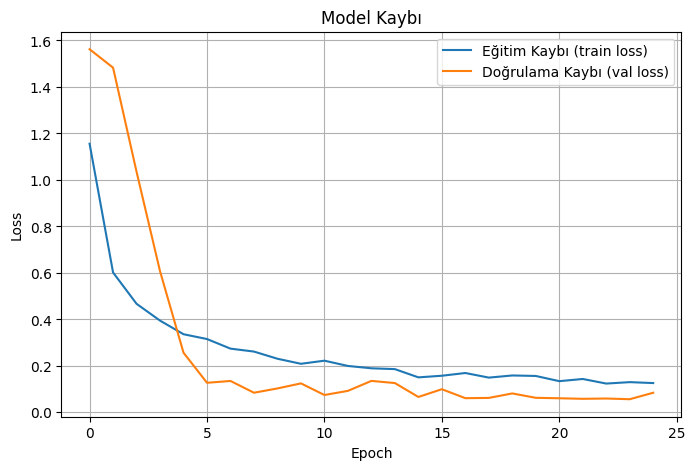

In [3]:
import matplotlib.pyplot as plt

def plot_loss(history):
    plt.figure(figsize=(8,5))
    plt.plot(history.history['loss'], label='Eğitim Kaybı (train loss)')
    plt.plot(history.history['val_loss'], label='Doğrulama Kaybı (val loss)')
    plt.title('Model Kaybı')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss(history)
